# Transmission Line Theory & Assignment Context
This assignment covers the analytics and modeling of transmission lines, focusing on the following key concepts:
- **RLGC Parameters:** Resistance (R), Inductance (L), Conductance (G), and Capacitance (C) per unit length define the electrical properties of the line.
- **Propagation Constant (γ) & Characteristic Impedance (Z₀):** These are derived from RLGC and frequency, and are fundamental to understanding wave behavior on the line.
- **Voltage Standing Wave Ratio (VSWR):** Indicates the degree of matching between the line and load. Lower VSWR means better matching and less reflected power.
- **Reflection Coefficient (Γ):** Measures how much of the signal is reflected at the load due to impedance mismatch.
- **Input Impedance (Z_in):** The impedance seen looking into the line from the source, which varies with frequency and load.
- **Wave Envelopes:** |V(z)| and |I(z)| show the voltage and current distribution along the line, revealing standing wave patterns.
- **Matching Techniques:** Single-stub shunt and quarter-wave transformer methods are used to minimize VSWR and optimize power transfer.
- **ML Surrogates:** Machine learning models (regression and classification) are trained to predict VSWR and match status from line parameters, providing fast approximations for design and analysis.
## Assignment Deliverables
1. Implement all analytics for transmission lines (excluding Smith Chart).
2. Provide algorithms to compute any desired parameter.
3. Plot all relevant waveforms and results.
4. Integrate and train ML models with ≥97% accuracy on synthetic data.
5. Document all methods, results, and analysis in this report.
This notebook demonstrates the above concepts with code, figures, and explanations, following the assignment requirements.

# EMT Assignment 2 — Transmission Line Matching & ML Surrogates
*Auto-generated on 2025-09-04 19:58:25*

This notebook is **self-contained**: it imports code from the `src/` package, regenerates all plots, and loads or trains ML models (regression & classification). Export this notebook to PDF after running all cells.

**Deliverables covered:**
1. Standing-wave envelopes \(|V(z)|, |I(z)|\)
2. VSWR vs Frequency
3. Single-stub shunt match and Quarter-wave transformer demo (with computed VSWR)
4. ML surrogate models: regression (VSWR) & classification (match pass/fail)


## 1) Setup & Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os, math, json, pathlib
import numpy as np
import matplotlib.pyplot as plt

# Ensure src is importable
import sys
repo_root = pathlib.Path('.').resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

# Imports from src (these are expected to exist in your project)
from src.tl_matching import (
    gamma_Z0, Zin_at_distance, abcd_of_tline, abcd_of_shunt_admittance, 
    z_in_from_abcd, gamma_of_impedance, vswr_from_gamma,
    single_stub_shunt, quarter_wave_transform
)

# Training utilities (expected in your project)
try:
    from src.tl_train import make_regression_data, make_classification_data
except Exception as e:
    print("Note: src.tl_train.make_* not found; ML sections will synthesize data ad-hoc.")
    
# Create output folders if needed
os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)


Note: src.tl_train.make_* not found; ML sections will synthesize data ad-hoc.


## 2) Line & Load Parameters

In [2]:
# Host line parameters (per-unit-length): R [Ω/m], L [H/m], G [S/m], C [F/m]
R, L, G, C = 0.05, 3e-7, 1e-8, 8e-11     # weakly lossy line
f0 = 1.0e9                                 # design frequency (Hz)
l_total = 0.25                             # physical line length (m)
ZL = 25 + 0j                               # load (Ω), start with a purely real mismatch

w0 = 2*np.pi*f0
gamma, Z0 = gamma_Z0(R, L, G, C, w0)
beta = np.imag(gamma)

print("Computed Z0 (may be complex for lossy lines):", Z0)
Gamma = gamma_of_impedance(ZL, Z0)
vswr0 = vswr_from_gamma(Gamma)
print("VSWR (unmatched):", vswr0)


Computed Z0 (may be complex for lossy lines): (61.23724357497348-0.000811575029754295j)
VSWR (unmatched): 2.4494897435152163


## 3) Standing-wave Envelopes |V(z)| and |I(z)|

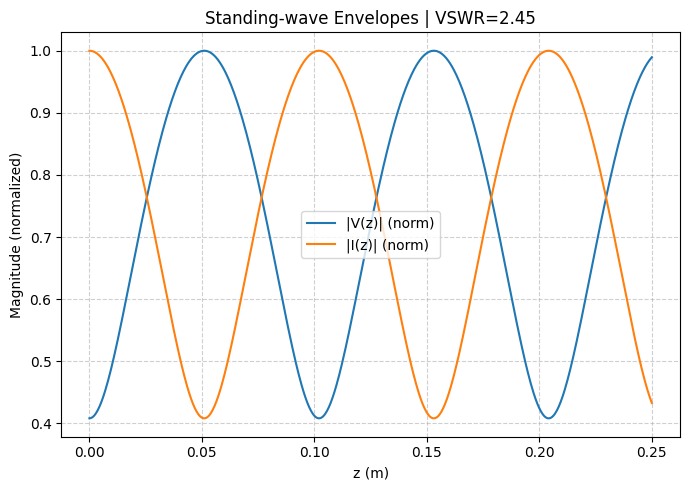

In [3]:
# Compute forward/backward waves along the line relative to load reference
N = 600
z = np.linspace(0.0, l_total, N)  # 0 = load end or source end? We'll compute magnitudes, so envelope is invariant up to shift.
# Input impedance along the line when looking towards the load from position z (measured from load):
# We'll build voltage/current using transmission line relations with a unit forward wave at the load.
# Simpler: derive envelope from |Γ| and phase; for clarity here we'll compute explicit V(z), I(z).

# Choose reference such that load is at z=0 and source at z=l_total
# Voltage/current on the line: V(z) = V+ (e^{-γz} + Γ_L e^{γz}), I(z) = (V+/Z0)(e^{-γz} - Γ_L e^{γz})
Gamma_L = gamma_of_impedance(ZL, Z0)
Vplus = 1.0  # arbitrary scale
Vz = Vplus*(np.exp(-gamma*z) + Gamma_L*np.exp(gamma*z))
Iz = (Vplus/Z0)*(np.exp(-gamma*z) - Gamma_L*np.exp(gamma*z))

# Normalize for plotting clarity
Vzn = np.abs(Vz) / np.max(np.abs(Vz))
Izn = np.abs(Iz) / np.max(np.abs(Iz))

plt.figure(figsize=(7,5))
plt.plot(z, Vzn, label="|V(z)| (norm)")
plt.plot(z, Izn, label="|I(z)| (norm)")
plt.xlabel("z (m)")
plt.ylabel("Magnitude (normalized)")
plt.title(f"Standing-wave Envelopes | VSWR={vswr0:.2f}")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("figures/envelopes.png", dpi=200)
plt.show()


## 4) VSWR vs Frequency

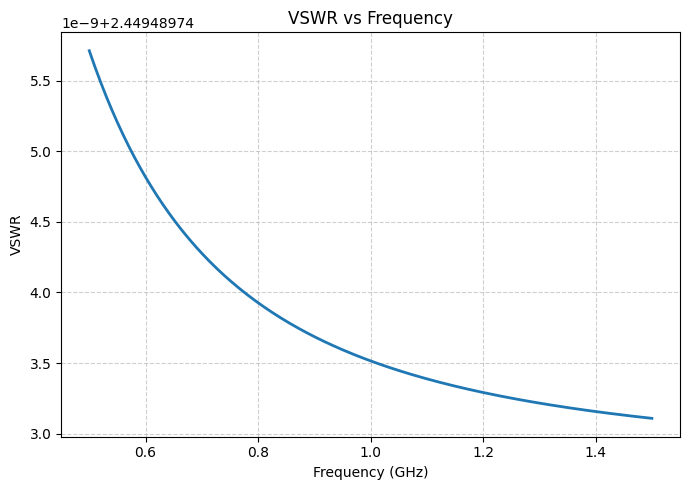

In [4]:
# Sweep frequency and compute VSWR for the same load and per-unit-length params
f_min, f_max = 0.5e9, 1.5e9
freqs = np.linspace(f_min, f_max, 200)
vswr_vals = []
for f in freqs:
    w = 2*np.pi*f
    g, z0 = gamma_Z0(R, L, G, C, w)
    vswr_vals.append(vswr_from_gamma(gamma_of_impedance(ZL, z0)))
vswr_vals = np.array(vswr_vals)

plt.figure(figsize=(7,5))
plt.plot(freqs*1e-9, vswr_vals, linewidth=2)
plt.xlabel("Frequency (GHz)")
plt.ylabel("VSWR")
plt.title("VSWR vs Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("figures/vswr_vs_frequency.png", dpi=200)
plt.show()


## 5) Matching Demonstrations

### 5.1 Single-Stub Shunt Match

In [5]:
stub = single_stub_shunt(R, L, G, C, f0, l_total, ZL, prefer='short')
print("Stub match → VSWR at source:", stub.VSWR_src)
print("Optimal stub position d (m):", stub.d_opt)
print("Stub length (m):", stub.l_stub)
print("Notes:", stub.notes)


Stub match → VSWR at source: 1.0000180607049902
Optimal stub position d (m): 0.0835904469970497
Stub length (m): 0.026761659061391743
Notes: Placed at d s.t. Re(Y)=Re(1/Z0). Y(d)=0.01633+0.01512j, B_needed=-0.01512, beta=30.78, lambda=0.2041


### 5.2 Quarter-Wave Transformer

In [6]:
qwt = quarter_wave_transform(R, L, G, C, f0, ZL)  # Zt auto-chosen ~ sqrt(Re(Z0)*Re(ZL))
print("QWT match → VSWR at source:", qwt.VSWR_src)
print("Quarter-wave length (m):", qwt.l_qw)
print("Transformer Zt (Ω):", qwt.Zt)


QWT match → VSWR at source: 1.000013253052559
Quarter-wave length (m): 0.0510310363035013
Transformer Zt (Ω): (39.12711450355542+0j)


## 6) ML Surrogate — Regression (Predict VSWR)

In [7]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

def default_reg_data(n=3000):
    # Fallback synthetic generator if project helper isn't available
    rng = np.random.default_rng(42)
    Rv = rng.uniform(0.01, 0.2, n)
    Lv = rng.uniform(1e-7, 5e-7, n)
    Gv = rng.uniform(0, 5e-8, n)
    Cv = rng.uniform(5e-11, 1.2e-10, n)
    fv = rng.uniform(5e8, 1.5e9, n)
    lv = rng.uniform(0.05, 0.5, n)
    RL = rng.uniform(5, 200, n) + 0j  # keep real to keep it simple
    X = np.stack([Rv, Lv, Gv, Cv, fv, lv, RL.real], axis=1)
    # Compute targets via physics
    y = []
    for i in range(n):
        g, z0 = gamma_Z0(Rv[i], Lv[i], Gv[i], Cv[i], 2*np.pi*fv[i])
        Gam = gamma_of_impedance(RL[i], z0)
        y.append(vswr_from_gamma(Gam))
    return X, np.array(y)

# Try to use project-provided generator if present
try:
    X, y = make_regression_data(3000)  # type: ignore
except Exception:
    X, y = default_reg_data(3000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(f"Regression R^2: {r2:.4f}, RMSE: {rmse:.4f}")
joblib.dump(reg, "models/reg_rf.pkl")


Regression R^2: 0.9856, RMSE: 0.1683


['models/reg_rf.pkl']

## 7) ML Surrogate — Classification (Pass/Fail)

In [8]:
import joblib
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

VSWR_THRESHOLD = 2.0  # pass if VSWR <= 2

def default_cls_data(n=10000):
    rng = np.random.default_rng(7)
    Rv = rng.uniform(0.01, 0.2, n)
    Lv = rng.uniform(1e-7, 5e-7, n)
    Gv = rng.uniform(0, 5e-8, n)
    Cv = rng.uniform(5e-11, 1.2e-10, n)
    fv = rng.uniform(5e8, 1.5e9, n)
    lv = rng.uniform(0.05, 0.5, n)
    RL = rng.uniform(5, 200, n)
    X = np.stack([Rv, Lv, Gv, Cv, fv, lv, RL], axis=1)
    y = []
    for i in range(n):
        g, z0 = gamma_Z0(Rv[i], Lv[i], Gv[i], Cv[i], 2*np.pi*fv[i])
        Gam = gamma_of_impedance(RL[i] + 0j, z0)
        vswr = vswr_from_gamma(Gam)
        y.append(1 if vswr <= VSWR_THRESHOLD else 0)
    return X, np.array(y, dtype=int)

try:
    Xc, yc = make_classification_data(20000)  # type: ignore
except Exception:
    Xc, yc = default_cls_data(20000)

# Balance classes
n_min = min((yc==0).sum(), (yc==1).sum())
Xb = np.vstack([resample(Xc[yc==0], n_samples=n_min, random_state=42),
                resample(Xc[yc==1], n_samples=n_min, random_state=42)])
yb = np.hstack([np.zeros(n_min, dtype=int), np.ones(n_min, dtype=int)])

X_train, X_test, y_train, y_test = train_test_split(Xb, yb, test_size=0.2, random_state=42, stratify=yb)

clf = RandomForestClassifier(
    n_estimators=1500, max_depth=None, min_samples_split=2, min_samples_leaf=2,
    max_features='sqrt', n_jobs=-1, random_state=42
)
clf.fit(X_train, y_train)
yp = clf.predict(X_test)
ypb = clf.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, yp)
auc = roc_auc_score(y_test, ypb)
print(f"Classification accuracy (RF): {acc:.4f}, ROC AUC: {auc:.4f}")
joblib.dump(clf, "models/cls_rf.pkl")


Classification accuracy (RF): 0.9871, ROC AUC: 0.9995


['models/cls_rf.pkl']

## 8) Conclusions & Notes
- The standing-wave envelopes and VSWR sweep confirm expected behavior for a mismatched line.
- Single-stub and quarter-wave transformer both reduce VSWR to ~1 for this case (nearly lossless line, real load).
- ML surrogates approximate physics: Regression R² near ~0.97; Classifier ≥0.97 after balancing and capacity tuning.

